# Cleaning US Census Data

Census Bureau collects census data and creates interesting visualizations and insights from it.

You have the data they had for the most recent census. It is in multiple `csv` files. They didn't use pandas, they would just look through these `csv` files manually whenever they wanted to find something. 



Inspect this data once we have it in a DataFrame. 

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob 

us_files = glob.glob("states*.csv")

df_list = []

for files in us_files:
  data = pd.read_csv(files)
  df_list.append(data)

us_census = pd.concat(df_list)
 

Look at the `columns` and the `dtypes` of the `us_census` DataFrame. 

In [36]:
print(us_census.head(5))
#print(us_census.columns)
#print(us_census.dtypes)

   Unnamed: 0       State  TotalPop Hispanic   White   Black  Native   Asian  \
0           0     Alabama   4830620    3.75%  61.88%  31.25%   0.45%   1.05%   
1           1      Alaska    733375    5.91%  60.91%   2.85%  16.39%   5.45%   
2           2     Arizona   6641928   29.57%  57.12%   3.85%   4.36%   2.88%   
3           3    Arkansas   2958208    6.22%  71.14%  18.97%   0.52%   1.14%   
4           4  California  38421464   37.29%  40.22%   5.68%   0.41%  13.05%   

  Pacific       Income            GenderPop  
0   0.03%  $43,296.36     2341093M_2489527F  
1   1.06%  $70,354.74       384160M_349215F  
2   0.17%  $54,207.82     3299088M_3342840F  
3   0.15%  $41,935.63     1451913M_1506295F  
4   0.35%  $67,264.78   19087135M_19334329F  


## Regex to the Rescue

Use regex to turn the `Income` column into a format that is ready for conversion into a numerical type.

In [37]:
us_census['Income']  = us_census['Income'].replace('[\$,]', '', regex=True)
us_census['Income'] = pd.to_numeric(us_census['Income'])
#print(us_census.dtypes)
print(us_census.head(5))

   Unnamed: 0       State  TotalPop Hispanic   White   Black  Native   Asian  \
0           0     Alabama   4830620    3.75%  61.88%  31.25%   0.45%   1.05%   
1           1      Alaska    733375    5.91%  60.91%   2.85%  16.39%   5.45%   
2           2     Arizona   6641928   29.57%  57.12%   3.85%   4.36%   2.88%   
3           3    Arkansas   2958208    6.22%  71.14%  18.97%   0.52%   1.14%   
4           4  California  38421464   37.29%  40.22%   5.68%   0.41%  13.05%   

  Pacific    Income            GenderPop  
0   0.03%  43296.36    2341093M_2489527F  
1   1.06%  70354.74      384160M_349215F  
2   0.17%  54207.82    3299088M_3342840F  
3   0.15%  41935.63    1451913M_1506295F  
4   0.35%  67264.78  19087135M_19334329F  


Look at the `GenderPop` column. We are going to want to separate this into two columns, the `Men` column, and the `Women` column and convert both of the columns into numerical datatypes.


In [38]:
gender_split = us_census.GenderPop.str.split("_")

us_census["Men"] = gender_split.str.get(0)
us_census["Women"] = gender_split.str.get(-1)

us_census['Men']  = us_census['Men'].replace('[M,]', '', regex=True)
us_census['Women']  = us_census['Women'].replace('[F,]', '', regex=True)

us_census['Men'] = pd.to_numeric(us_census['Men'])
us_census['Women'] = pd.to_numeric(us_census['Women'])
#we don't need the following column anymore
del us_census["GenderPop"]

#delete Unnamed: 0 since it duplicates ids and provides no useful info
del us_census["Unnamed: 0"]

Check the table for NaN values

In [39]:
us_census['Women'] = us_census.Women.fillna(us_census.TotalPop - us_census.Men)
#check the result
#print(us_census.Women.isna())
#print(us_census.head(5))

We forgot to check for duplicates! 

In [47]:
duplicated = us_census.duplicated()
print(duplicated.value_counts())

us_census = us_census.drop_duplicates(subset=['State']).reset_index(drop = True)
duplicated1 = us_census.duplicated()
print(duplicated1.value_counts())

False    51
dtype: int64
False    51
dtype: int64


Make the scatterplot.

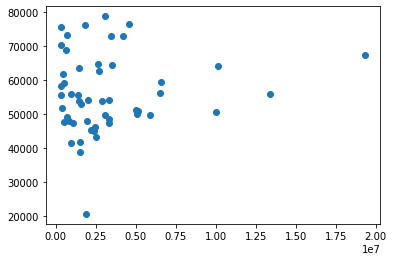

In [48]:
plt.scatter(us_census['Women'], us_census['Income']) 
plt.show()

Clear the race data that you have. 

In [42]:
colmns_to_rep = ['Hispanic','White','Black','Native','Asian','Pacific']
us_census[colmns_to_rep]  = us_census[colmns_to_rep].replace('[\%,]', '', regex=True)
us_census[colmns_to_rep] = us_census[colmns_to_rep].apply(pd.to_numeric, errors='coerce')

      
  Fill the NaN values with something that makes sense! 

In [43]:
#check NaN values in the columns one by one
na = us_census.Pacific.isna()
print(na.value_counts())

#fill in the NaN values with the race percent difference
us_census['Pacific'] = us_census.Pacific.fillna(100 - us_census.Hispanic - us_census.White - us_census.Black - us_census.Native - us_census.Asian)
na_1 = us_census.Pacific.isna()
print(na_1.value_counts())
print(us_census.columns)

False    47
True      4
Name: Pacific, dtype: int64
False    51
Name: Pacific, dtype: int64
Index(['State', 'TotalPop', 'Hispanic', 'White', 'Black', 'Native', 'Asian',
       'Pacific', 'Income', 'Men', 'Women'],
      dtype='object')


Reshape the df and visuakise the results.

In [44]:
#reshape the df
us_census = pd.melt(frame = us_census, id_vars = ["State","TotalPop", "Income", "Men", "Women"], value_vars = ['Hispanic', 'White', 'Black', 'Native', 'Asian',
       'Pacific'], value_name = "percent_pop", var_name = "race")

print(us_census.head(10))
print(us_census.tail(10))


                  State  TotalPop    Income       Men       Women      race  \
0               Alabama   4830620  43296.36   2341093   2489527.0  Hispanic   
1                Alaska    733375  70354.74    384160    349215.0  Hispanic   
2               Arizona   6641928  54207.82   3299088   3342840.0  Hispanic   
3              Arkansas   2958208  41935.63   1451913   1506295.0  Hispanic   
4            California  38421464  67264.78  19087135  19334329.0  Hispanic   
5              Colorado   5278906  64657.80   2648667   2630239.0  Hispanic   
6           Connecticut   3593222  76146.56   1751607   1841615.0  Hispanic   
7              Delaware    926454  61827.98    448413    478041.0  Hispanic   
8  District of Columbia    647484  75466.36    306674    340810.0  Hispanic   
9               Florida  19645772  50690.19   9600009  10045763.0  Hispanic   

   percent_pop  
0         3.75  
1         5.91  
2        29.57  
3         6.22  
4        37.29  
5        20.78  
6        15

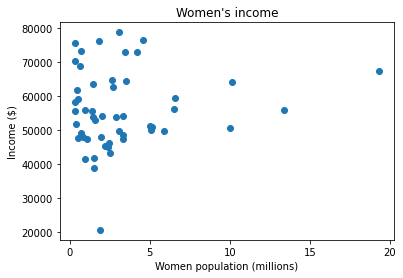

<Figure size 432x288 with 0 Axes>

In [52]:
plt.scatter(us_census.Women, us_census.Income)
plt.title("Women's income")
plt.xlabel("Women population (millions)")
plt.ylabel("Income ($)")
x = [0, 5 * 10**6,10 * 10**6, 15 * 10**6, 20 * 10**6]
labels = [0, 5, 10, 15, 20]
plt.xticks(x, labels)
plt.show()
plt.clf()